In [367]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import r2_score, recall_score, mean_absolute_percentage_error
import matplotlib.ticker as ticker

Описание датасета:

In [368]:
df = pd.read_csv('train_dataset_train.csv')
df.head()

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
1,2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
2,3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
3,4,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
4,5,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017


In [369]:
cols = df.columns
"""
for col in cols:
    print(f"Характеристика: {col}")
    print(f"Количество уникальных значений: {df[col].nunique()}", "\n")
    print(f"Список значений:\n{df[col]}")
    #print(df[col])
    print('///////////////////////////////////////////////////', "\n")
"""

'\nfor col in cols:\n    print(f"Характеристика: {col}")\n    print(f"Количество уникальных значений: {df[col].nunique()}", "\n")\n    print(f"Список значений:\n{df[col]}")\n    #print(df[col])\n    print(\'///////////////////////////////////////////////////\', "\n")\n'

Посмотрим заполненность данных и выявим есть ли пропуски:

In [370]:
for col in cols:
    print(f'Столбец: {col}, число пропусков:\t {df[col].isna().sum()}')

Столбец: id, число пропусков:	 0
Столбец: ticket_id, число пропусков:	 0
Столбец: ticket_type_nm, число пропусков:	 0
Столбец: entrance_id, число пропусков:	 0
Столбец: entrance_nm, число пропусков:	 0
Столбец: station_id, число пропусков:	 0
Столбец: station_nm, число пропусков:	 0
Столбец: line_id, число пропусков:	 0
Столбец: line_nm, число пропусков:	 0
Столбец: pass_dttm, число пропусков:	 0
Столбец: time_to_under, число пропусков:	 0
Столбец: label, число пропусков:	 0


In [371]:
df = df.drop(['id', 'entrance_nm', 'station_id', 'line_id', 'entrance_id', 'ticket_id'], axis=1)

In [372]:
df

,ticket_type_nm,station_nm,line_nm,pass_dttm,time_to_under,label
0,Пропуск FacePay,Лефортово,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
1,СК учащегося 30 дней,Войковская,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
2,БСК дружинника г.Москвы,Войковская,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
3,30 дней,Войковская,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
4,КОШЕЛЕК,Войковская,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017
...,...,...,...,...,...,...
1091016,Пропуск FacePay,Нижегородская,Некрасовская,2022-09-19 02:54:50,124.750000,15005
1091017,Пропуск FacePay,Калужская,Калужско-Рижская,2022-09-19 03:06:02,56.066667,6007
1091018,Пропуск FacePay,Каширская,Замоскворецкая,2022-09-19 03:17:00,91.283333,2010
1091019,Пропуск FacePay,Воронцовская,Большая кольцевая,2022-09-19 03:23:30,47.900000,11014


Далее поработаем отдельно с каждый столбцом. Столбец ticket_type_nm можно разделить по категориям: студенты, рабочие итд..., 
Стоблец pass_dttm можно разделить по дням и часам для того, чтобы отсеять периоды "Малой активности".
Займемся этим по порядку:


1) Рассмотрим столбец с пропусками: 

In [373]:
print(df.ticket_type_nm.unique())
print(len(df.ticket_type_nm.unique()))

['Пропуск FacePay' 'СК учащегося 30 дней' 'БСК дружинника г.Москвы'
 '30 дней' 'КОШЕЛЕК' 'СК студента 30 дней' '90 дней' '90 дней ЕДИНЫЙ ТК'
 '30 дней СК учащегося' '90 дней СК студента' '30 дней СК студента' 'ББК'
 'СК аспиранта 90 дней' 'Социальная карта москвича' '30 дней ЕДИНЫЙ ТК'
 'Социальная карта жителя Моск. области' '30 дней Пригород ТК'
 'Социальная карта москвича с сопровождающим'
 'Пропуск сотрудника УВД по охране Метрополитена' '60 поездок ЕДИНЫЙ ТК'
 'СК для сотрудника ГУВД г.Москвы' '365 дней ЕДИНЫЙ ТК'
 'ВЕСБ МОСКВА (7мин)' 'СК студента 90 дней' '90 дней Пригород ТК'
 '30 дней  Пригород' '365 дней Пригород ТК' '365 дней'
 'СК ординатора 30 дней' '30 дней СК аспиранта' '30 дней СК ординатора'
 '90 дней СК ординатора' 'ВЕСБ МО (7 мин)' 'ВЕСБ МО (тип 5)'
 'СК ординатора 90 дней' 'СК аспиранта 30 дней' '90 дней СК учащегося'
 'Временный билет ММ'
 'Социальная карта жителя Моск. области с сопровождающим'
 'СК учащегося 90 дней' '3 суток Единый ТК'
 'Пропуск сотрудника  метр

In [374]:
studentPass = ['СК студента 30 дней', 'СК учащегося 30 дней', '30 дней СК учащегося', '90 дней СК студента',
                '30 дней СК студента', 'СК ординатора 90 дней', 'СК аспиранта 90 дней', 'СК учащегося 90 дней',
                'СК аспиранта 30 дней', '90 дней СК учащегося', 'СК ординатора 30 дней', '30 дней СК аспиранта',
                '30 дней СК ординатора', '90 дней СК ординатора', 'СК студента 90 дней', '90 дней СК аспиранта']
subwayWorkerPass = ['Пропуск сотрудника УВД по охране Метрополитена', 'Пропуск сотрудника МЦК',
                   'Пропуск руководителя метрополитена', 'Пропуск сотрудника метрополитена',
                   'СК ассистента-стажера 30 дней', 'СК ассистента-стажера 90 дней', '30 дней СК ассистента-стажера', 
                    'Пропуск  сотрудника МЦК', 'Пропуск сотрудника  метрополитена']
moneyPass = ['Пропуск FacePay', 'КОШЕЛЕК', 'Безналичная транспортная карта']
socialPass = ['Социальная карта жителя Моск. области с сопровождающим', 'Социальная карта жителя Моск. области', 
              'Социальная карта москвича с сопровождающим', 'Социальная карта москвича', 'БСК дружинника г.Москвы', 
              'СК для сотрудника ГУВД г.Москвы', 'ВЛБ МОСКВА', 'ВЕСБ МО с сопровождающим', 'ВЕСБ МОСКВА (7мин)', 
              'ВЕСБ МО (тип 5)', 'ВЕСБ МО (тип 6)', 'ВЕСБ МОСКВА', 'ВЕСБ МО (7 мин)', 'Временный билет ММ']
suburbanPass = ['1 сутки Пригород ТК', '90 дней Пригород', '365 дней Пригород', '30 дней Пригород', '90 дней Пригород ТК',
                '30 дней Пригород ТК', '365 дней Пригород ТК', 'ББК', '30 дней  Пригород', '90 дней  Пригород', '365 дней  Пригород']
justPass = ['30 дней', '90 дней', '30 дней ЕДИНЫЙ ТК', '60 поездок ЕДИНЫЙ ТК', '365 дней ЕДИНЫЙ ТК' , '365 дней', 
            '3 суток Единый ТК', '1 сутки ЕДИНЫЙ ТК', 'Ультралайт Единый (70)', 'Билет 3 суток ЕДИНЫЙ', 'Билет 3 суток ЕДИНЫЙ',
            '90 дней ЕДИНЫЙ ТК', 'Билет 1 сутки ЕДИНЫЙ']

In [375]:
df['ticket_type_nm'].mask(df.ticket_type_nm.isin(subwayWorkerPass), 'subwayWorkerPass', inplace=True)
df['ticket_type_nm'].mask(df.ticket_type_nm.isin(moneyPass), 'moneyPass', inplace=True)
df['ticket_type_nm'].mask(df.ticket_type_nm.isin(studentPass), 'studentPass', inplace=True)
df['ticket_type_nm'].mask(df.ticket_type_nm.isin(suburbanPass), 'suburbanPass', inplace=True)
df['ticket_type_nm'].mask(df.ticket_type_nm.isin(socialPass), 'socialPass', inplace=True)
df['ticket_type_nm'].mask(df.ticket_type_nm.isin(justPass), 'justPass', inplace=True)

In [376]:
df

,ticket_type_nm,station_nm,line_nm,pass_dttm,time_to_under,label
0,moneyPass,Лефортово,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
1,studentPass,Войковская,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
2,socialPass,Войковская,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
3,justPass,Войковская,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
4,moneyPass,Войковская,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017
...,...,...,...,...,...,...
1091016,moneyPass,Нижегородская,Некрасовская,2022-09-19 02:54:50,124.750000,15005
1091017,moneyPass,Калужская,Калужско-Рижская,2022-09-19 03:06:02,56.066667,6007
1091018,moneyPass,Каширская,Замоскворецкая,2022-09-19 03:17:00,91.283333,2010
1091019,moneyPass,Воронцовская,Большая кольцевая,2022-09-19 03:23:30,47.900000,11014


Таким образом мы уменьшили количество признаков столбца ticket_type_nm c 60ти до 6ти

2) Далее поработаем с датой и временем. Разделим столбец pass_dttm на часы и дни. Построим гистограмму.

In [377]:
df["pass_dttm"] = pd.to_datetime(df["pass_dttm"])
df_tmp= df["pass_dttm"].dt.hour
df_tmp = df_tmp.value_counts()
df_tmp = df_tmp.reset_index().rename(columns = {'index': 'hour', 'pass_dttm': 'number_of_people'})
df_tmp

,hour,number_of_people
0,8,232006
1,7,208545
2,9,141080
3,6,116616
4,10,77730
5,11,54940
6,12,42521
7,13,38645
8,14,32010
9,15,28072


<AxesSubplot:xlabel='hour', ylabel='number_of_people'>

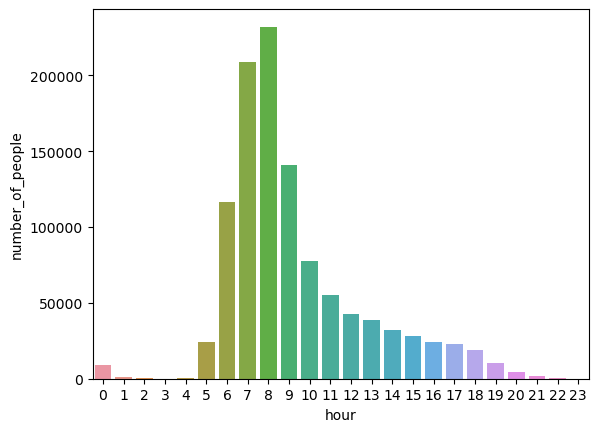

In [378]:
sns.barplot(x = df_tmp["hour"], y = df_tmp["number_of_people"])

То же самое делаем для дней:

In [379]:
df_tmp2 = df["pass_dttm"].dt.weekday
df_tmp2 = df_tmp2.value_counts()
df_tmp2 = df_tmp2.reset_index().rename(columns = {'index': 'day', 'pass_dttm': 'number_of_people'})
df_tmp2

,day,number_of_people
0,0,169081
1,1,169068
2,2,168584
3,3,166645
4,4,160868
5,5,136813
6,6,119962


<AxesSubplot:xlabel='day', ylabel='number_of_people'>

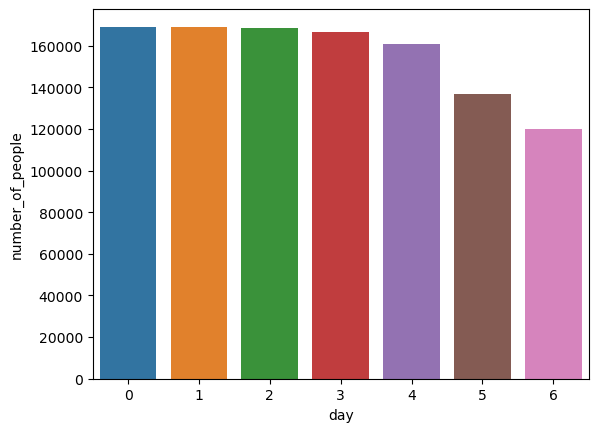

In [380]:
sns.barplot(x = df_tmp2["day"], y = df_tmp2["number_of_people"])

In [381]:
df.pass_dttm = pd.to_datetime(df.pass_dttm)
df['dayOfWeek'] = df.pass_dttm.dt.weekday
df['hour'] = df.pass_dttm.dt.hour
df.drop(['pass_dttm'], axis=1)

,ticket_type_nm,station_nm,line_nm,time_to_under,label,dayOfWeek,hour
0,moneyPass,Лефортово,Большая кольцевая,216.316667,8001,0,5
1,studentPass,Войковская,Замоскворецкая,648.183333,9011,0,5
2,socialPass,Войковская,Замоскворецкая,865.333333,7022,0,5
3,justPass,Войковская,Замоскворецкая,1048.233333,2022,0,5
4,moneyPass,Войковская,Замоскворецкая,965.600000,2017,0,5
...,...,...,...,...,...,...,...
1091016,moneyPass,Нижегородская,Некрасовская,124.750000,15005,0,2
1091017,moneyPass,Калужская,Калужско-Рижская,56.066667,6007,0,3
1091018,moneyPass,Каширская,Замоскворецкая,91.283333,2010,0,3
1091019,moneyPass,Воронцовская,Большая кольцевая,47.900000,11014,0,3


In [382]:
rushHour = [5, 6, 7, 8, 9, 10]
df['isRushHour'] = False
df['isRushHour'].mask(df.hour.isin(rushHour), True, inplace=True)

weekend = [5, 6]
df['isWeekend'] = False
df['isWeekend'].mask(df.dayOfWeek.isin(weekend), True, inplace=True)

df = df.drop(['pass_dttm'], axis=1)


In [383]:
df

,ticket_type_nm,station_nm,line_nm,time_to_under,label,dayOfWeek,hour,isRushHour,isWeekend
0,moneyPass,Лефортово,Большая кольцевая,216.316667,8001,0,5,True,False
1,studentPass,Войковская,Замоскворецкая,648.183333,9011,0,5,True,False
2,socialPass,Войковская,Замоскворецкая,865.333333,7022,0,5,True,False
3,justPass,Войковская,Замоскворецкая,1048.233333,2022,0,5,True,False
4,moneyPass,Войковская,Замоскворецкая,965.600000,2017,0,5,True,False
...,...,...,...,...,...,...,...,...,...
1091016,moneyPass,Нижегородская,Некрасовская,124.750000,15005,0,2,False,False
1091017,moneyPass,Калужская,Калужско-Рижская,56.066667,6007,0,3,False,False
1091018,moneyPass,Каширская,Замоскворецкая,91.283333,2010,0,3,False,False
1091019,moneyPass,Воронцовская,Большая кольцевая,47.900000,11014,0,3,False,False


In [385]:
x_train_class = df.drop(columns=['label'])[:600]
y_train_class = df[['label']][:600]

test_class = df.loc[df.ticket_type_nm.isin(x_train_class.ticket_type_nm)&
                    df.station_nm.isin(x_train_class.station_nm) &
                    df.line_nm.isin(x_train_class.line_nm) ]

x_test_class = test_class.drop(columns=['label'])[:180]
y_test_class = test_class[['label']][:180]


In [389]:
pipe_multiclass = Pipeline(steps=[('model', CatBoostClassifier(cat_features=['ticket_type_nm', 'station_nm','line_nm', 'hour','isRushHour', 'isWeekend']))])
pipe_multiclass.fit(x_train_class, y_train_class)
forecast_class = pipe_multiclass.predict(x_test_class)

Learning rate set to 0.077092
0:	learn: 5.2834347	total: 8.46s	remaining: 2h 20m 55s
1:	learn: 5.2524016	total: 18.4s	remaining: 2h 33m 14s
2:	learn: 5.2246126	total: 28.1s	remaining: 2h 35m 33s
3:	learn: 5.1922014	total: 38.5s	remaining: 2h 39m 51s
4:	learn: 5.1673632	total: 48.4s	remaining: 2h 40m 24s
5:	learn: 5.1418646	total: 57.8s	remaining: 2h 39m 38s
6:	learn: 5.1164272	total: 1m 7s	remaining: 2h 39m 36s
7:	learn: 5.0930523	total: 1m 17s	remaining: 2h 40m 6s
8:	learn: 5.0636957	total: 1m 28s	remaining: 2h 42m 5s
9:	learn: 5.0404099	total: 1m 38s	remaining: 2h 41m 47s
10:	learn: 5.0121438	total: 1m 48s	remaining: 2h 42m 8s
11:	learn: 4.9853050	total: 1m 57s	remaining: 2h 41m 36s
12:	learn: 4.9561093	total: 2m 7s	remaining: 2h 40m 47s
13:	learn: 4.9246054	total: 2m 16s	remaining: 2h 40m 44s
14:	learn: 4.9023532	total: 2m 26s	remaining: 2h 40m 46s
15:	learn: 4.8737493	total: 2m 37s	remaining: 2h 40m 56s
16:	learn: 4.8441255	total: 2m 47s	remaining: 2h 41m 16s
17:	learn: 4.8157015	t

In [392]:
print('recall: ',recall_score(y_test_class, forecast_class, average='micro'))

recall:  0.20555555555555555


In [ ]:
# 0.5253062910238631 - catboost R2 - the best


In [393]:
 print('Score :'  ,0.5 * 0.5253062910238631 + 0.5 * 0.20555555555555555)

Score : 0.3654309232897093


XGBoost

In [ ]:
#import xgboost as xgb

In [ ]:
#encoder = LabelEncoder()
#encoder.fit(data_new['label'])

In [ ]:
#y_train_enc = encoder.transform(y_train_class)
#y_test_enc = encoder.transform(y_test_class)

In [ ]:
#model_xgb = xgb.XGBClassifier(subsample=0.2, n_estimators=50)
#model_xgb.fit(x_train_class, y_train_enc)

In [ ]:
#y_pred_xgb = model_xgb.predict(x_test_class)

In [ ]:
#print(recall_score(y_test_enc, y_pred_xgb, average='weighted'))
#print(r2_score(y_test_enc, y_pred_xgb))

In [395]:
#0.5*0.07006666666666667 + 0.5*(0.5253062910238631)